In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


### Get the Data, Explore and Visualize ###

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

180921.19589041095


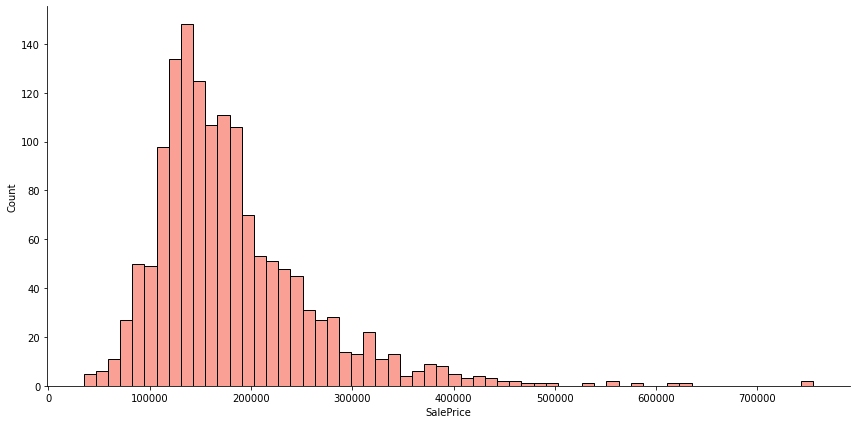

In [4]:
# Sale price distribution
print(df_train['SalePrice'].mean())
sns.displot(df_train, x='SalePrice', height=6, aspect=2, bins=60, color='salmon')

### Remove Outliers ###

In [5]:
df_train = df_train[df_train['SalePrice'] < 600000]

In [6]:
# Check the correlation of each feature
# Potentiall drop out features which have low correlation (<0.2) with Sale Price since there are 81 features total
df_train.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.798004
GrLivArea        0.691034
GarageCars       0.651630
GarageArea       0.634058
TotalBsmtSF      0.605791
1stFlrSF         0.596491
FullBath         0.558121
YearBuilt        0.539240
TotRmsAbvGrd     0.528314
YearRemodAdd     0.526217
GarageYrBlt      0.502955
Fireplaces       0.464401
MasVnrArea       0.450840
BsmtFinSF1       0.360712
LotFrontage      0.332741
OpenPorchSF      0.329547
WoodDeckSF       0.324530
2ndFlrSF         0.293729
HalfBath         0.279427
LotArea          0.261000
BsmtFullBath     0.231081
BsmtUnfSF        0.229938
BedroomAbvGr     0.162933
ScreenPorch      0.123285
MoSold           0.062310
3SsnPorch        0.049468
PoolArea         0.029813
BsmtFinSF2      -0.006743
MiscVal         -0.020869
LowQualFinSF    -0.024955
YrSold          -0.025256
Id              -0.034198
BsmtHalfBath    -0.035687
OverallCond     -0.077834
MSSubClass      -0.087090
EnclosedPorch   -0.129846
KitchenAbvGr    -0.140343
Name: SalePr

### Investigating The Unique Entries in each Categorical Data ###

In [7]:
# Obtain all the object data. Print each category with its unique entry number
object_list_train = df_train.select_dtypes(include='object').columns.tolist()
cardinality_total = list(map(lambda x: df_train[x].nunique(), object_list_train))
d = dict(zip(object_list_train, cardinality_total))
sorted_d = sorted(d.items(), key=lambda x: x[1])

def extract_entries(cardinality_level):
    cardinality_num = list(map(lambda x: df_train[x].nunique(), cardinality_level))
    d_level = dict(zip(cardinality_level, cardinality_num))
    sorted_d_level = sorted(d_level.items(), key=lambda x: x[1])
    total_entries_added = sum(cardinality_num)
    return ('Total entries added: ' + str(total_entries_added) + '\n' +
           str(sorted_d_level))

# Separate the category which has small unique entries
low_cardinality_train = [cols for cols in object_list_train if df_train[cols].nunique() < 10]


# Extract category which has high number of unique entries
high_cardinality_train = list(set(object_list_train) - set(low_cardinality_train))\

print('Small Cardinality Numbers:')
print(extract_entries(low_cardinality_train))
print('\n')
print('Big Cardinality Numbers:')
print(extract_entries(high_cardinality_train))

Small Cardinality Numbers:
Total entries added: 196
[('Street', 2), ('Alley', 2), ('Utilities', 2), ('CentralAir', 2), ('LandSlope', 3), ('GarageFinish', 3), ('PavedDrive', 3), ('PoolQC', 3), ('LotShape', 4), ('LandContour', 4), ('MasVnrType', 4), ('ExterQual', 4), ('BsmtQual', 4), ('BsmtCond', 4), ('BsmtExposure', 4), ('KitchenQual', 4), ('Fence', 4), ('MiscFeature', 4), ('MSZoning', 5), ('LotConfig', 5), ('BldgType', 5), ('ExterCond', 5), ('HeatingQC', 5), ('Electrical', 5), ('FireplaceQu', 5), ('GarageQual', 5), ('GarageCond', 5), ('RoofStyle', 6), ('Foundation', 6), ('BsmtFinType1', 6), ('BsmtFinType2', 6), ('Heating', 6), ('GarageType', 6), ('SaleCondition', 6), ('Functional', 7), ('Condition2', 8), ('HouseStyle', 8), ('RoofMatl', 8), ('Condition1', 9), ('SaleType', 9)]


Big Cardinality Numbers:
Total entries added: 56
[('Exterior1st', 15), ('Exterior2nd', 16), ('Neighborhood', 25)]


In [8]:
good_labels = [col for col in high_cardinality_train if set(df_test[col]).issubset(df_train[col])]
good_labels

['Neighborhood']

### Numerical Data ###

In [9]:
# Obtain all the numerical data for both train and test set
numerical_train = df_train.select_dtypes(exclude='object').columns.tolist()
numerical_test = df_test.select_dtypes(exclude='object').columns.tolist()

numerical_train

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

### Handling Missing Values ###

In [10]:
percentage = np.round(df_train.isnull().sum().sort_values(ascending=False)[:19]/len(df_train.index)*100, 2)
percentage_df = pd.DataFrame(percentage, columns=['Percentage of Missing Values'])
percentage_df

,Percentage of Missing Values
PoolQC,99.59
MiscFeature,96.29
Alley,93.75
Fence,80.77
FireplaceQu,47.39
LotFrontage,17.79
GarageYrBlt,5.56
GarageCond,5.56
GarageType,5.56
GarageFinish,5.56


In [11]:
# Separate missing values of categorical and numerical lists for observation

missing_object = [cols for cols in object_list_train if pd.isnull(df_train[cols]).any()]
missing_numerical = [cols for cols in numerical_train if pd.isnull(df_train[cols]).any()]
print(missing_object)
missing_numerical

['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

### Preprocessing Data using Pipeline ###

**Fill in LotFrontage First (since we can use Neighborhood to fill the NaN). Fill the rest with 0**

In [12]:
# Fill in the LotFrontage missing values by taking the mean of lotfrontage based on its neighborhood
neighbor = df_train.groupby('Neighborhood').mean()['LotFrontage']

def fill_lf(cols):
    neighborhood = cols[0]
    lf = cols[1]
    if pd.isnull(lf):
        return neighbor[neighborhood]
    else:
        return lf

df_train['LotFrontage'] = df_train[['Neighborhood', 'LotFrontage']].apply(fill_lf, axis=1)
df_test['LotFrontage'] = df_test[['Neighborhood', 'LotFrontage']].apply(fill_lf, axis=1)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Preprocessing for Categorical Data
categorical_transformer = Pipeline(steps=[
     ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='None')),
     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Before processing the numerical, remove the SalePrice and Id from the numerical list
numerical_train.remove('SalePrice')
numerical_train.remove('Id')

# Preprocessing for Numerical Data
numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Bundle and create the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_train),
    ('cat', categorical_transformer, object_list_train)
])

### Define The Model and Split the Data ###

**Model 1 with RandomForestRegressor**

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

X = df_train.drop(['SalePrice','Id'], axis=1)
y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {'n_estimators': [100, 150, 200, 250, 300, 350]}
model = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=3, verbose=3)

mypipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

mypipe.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=100, score=0.811, total=   1.7s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] .................... n_estimators=100, score=0.855, total=   1.7s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] .................... n_estimators=100, score=0.832, total=   1.7s
[CV] n_estimators=150 ................................................
[CV] .................... n_estimators=150, score=0.810, total=   2.5s
[CV] n_estimators=150 ................................................
[CV] .................... n_estimators=150, score=0.849, total=   2.6s
[CV] n_estimators=150 ................................................
[CV] .................... n_estimators=150, score=0.838, total=   2.5s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.815, total=   3.4s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.851, total=   3.4s
[CV] n_estimators=200 ................................................
[CV] .................... n_estimators=200, score=0.839, total=   3.4s
[CV] n_estimators=250 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.1min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'Bs...
                                  

**Model 2 with XGRegressor**

In [15]:
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model2 = XGBRegressor(n_estimators=1000, learning_rate=0.01)

X_train_xgb = preprocessor.fit_transform(X_train)
X_test_xgb = preprocessor.transform(X_test)

model2.fit(X_train_xgb, y_train, early_stopping_rounds=5, eval_set=[(X_test_xgb, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Evaluation

RMSE: 23622.018
MSLE: 0.016
MAE: 15362.225


Text(0, 0.5, 'predictions')

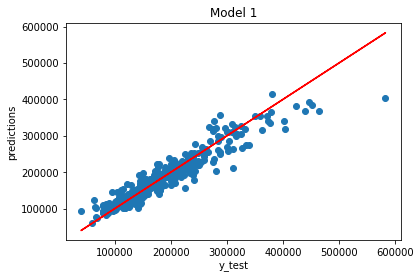

In [16]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
predictions = mypipe.predict(X_test)
print('RMSE: ' + str(round(np.sqrt(mean_squared_error(y_test, predictions)), 3)))
print('MSLE: ' + str(round(mean_squared_log_error(y_test, predictions), 3)))
print('MAE: ' + str(round(mean_absolute_error(y_test, predictions), 3)))

plt.scatter(x=y_test, y=predictions)
plt.plot(y_test, y_test, color='red')
plt.title('Model 1')
plt.xlabel('y_test')
plt.ylabel('predictions')

RMSE: 22165.581
MSLE: 0.015
MAE: 14852.774


Text(0, 0.5, 'predictions')

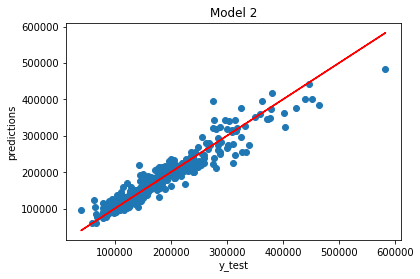

In [17]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

predictions2 = model2.predict(X_test_xgb)
print('RMSE: ' + str(round(np.sqrt(mean_squared_error(y_test, predictions2)), 3)))
print('MSLE: ' + str(round(mean_squared_log_error(y_test, predictions2), 3)))
print('MAE: ' + str(round(mean_absolute_error(y_test, predictions2), 3)))

plt.scatter(x=y_test, y=predictions2)
plt.plot(y_test, y_test, color='red')
plt.title('Model 2')
plt.xlabel('y_test')
plt.ylabel('predictions')

In [18]:
pred_test = model2.predict(preprocessor.transform(df_test.drop('Id', axis=1)))
result = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': pred_test})
result.to_csv('submission.csv', index=False)